# Decision Tree Training for Corruption Risk Prediction

**Goal**: Train a Decision Tree Classifier to predict corruption risk using 12 features (6 governance + 5 economic + 1 sentiment). The model serves as an interpretable early warning system for development integrity.

## Overview

This notebook trains a Decision Tree Classifier, chosen for its **interpretability** and robust performance on structured data (as outlined in the theoretical framework). The model learns patterns from:

1. **Governance Indicators (6 features)** - PRIMARY QUANTITATIVE SIGNAL
   - Directly measure institutional quality and determine corruption_risk labels
   - "Measurable governance indicators can reliably signal early signs of financial and political vulnerability"

2. **Economic Indicators (5 features)** - SECONDARY QUANTITATIVE SIGNAL
   - Provide complementary economic context

3. **Sentiment Analysis (1 feature)** - QUALITATIVE EARLY WARNING SIGNAL
   - Captures corruption visibility and transparency patterns

**Model Purpose**: Early warning system to detect high-risk environments before corruption scandals occur (e.g., Malaysia 1MDB, Mozambique hidden debt)

**Key Deliverable**: Visualized decision tree showing the model's decision-making process - "graphical representation will provide a clear, intuitive flowchart of the model's decision-making process"


In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import os

# set working directory to project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

print(f"Working directory: {os.getcwd()}")

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)


/var/folders/pk/_s3wzh8j3mbgc971jkb0__nc0000gn/T/ipykernel_32529/3499575780.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Working directory: /Users/snitil/Documents/innovationshowcase


## Section 1: Setup and Data Loading

Load the prepared training and test datasets from notebook 05, along with feature names.


In [2]:
# load training and test sets
train_df = pd.read_csv('data/processed/train_set.csv')
test_df = pd.read_csv('data/processed/test_set.csv')

# load feature names
with open('models/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print("="*70)
print("DATA LOADING")
print("="*70)
print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nFeatures ({len(feature_names)} total):")
for i, feature in enumerate(feature_names, 1):
    print(f"  {i:2d}. {feature}")

# extract feature matrix and target
X_train = train_df[feature_names]
y_train = train_df['corruption_risk']
X_test = test_df[feature_names]
y_test = test_df['corruption_risk']

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

print(f"\nTarget distribution (training set):")
print(y_train.value_counts())
print(f"\nTarget distribution (%):")
print(y_train.value_counts(normalize=True))

print(f"\nTarget distribution (test set):")
print(y_test.value_counts())
print(f"\nTarget distribution (%):")
print(y_test.value_counts(normalize=True))


DATA LOADING

Training set shape: (212, 13)
Test set shape: (54, 13)

Features (12 total):
   1. Voice_Accountability
   2. Political_Stability
   3. Government_Effectiveness
   4. Regulatory_Quality
   5. Rule_of_Law
   6. Control_of_Corruption
   7. GDP_Growth_annual_perc
   8. External_Debt_perc_GNI
   9. Govt_Expenditure_perc_GDP
  10. FDI_Inflows_perc_GDP
  11. Poverty_Headcount_Ratio
  12. sentiment_score

Feature matrix shapes:
  X_train: (212, 12)
  X_test: (54, 12)

Target distribution (training set):
corruption_risk
1    123
0     89
Name: count, dtype: int64

Target distribution (%):
corruption_risk
1    0.580189
0    0.419811
Name: proportion, dtype: float64

Target distribution (test set):
corruption_risk
1    31
0    23
Name: count, dtype: int64

Target distribution (%):
corruption_risk
1    0.574074
0    0.425926
Name: proportion, dtype: float64


## Section 2: Model Training

Initialize and train a Decision Tree Classifier with parameters optimized for interpretability and early warning performance:

- **max_depth=5**: Limits tree depth for interpretability and visualization
- **min_samples_split=10**: Prevents overfitting by requiring minimum samples to split
- **min_samples_leaf=5**: Prevents overfitting by requiring minimum samples in leaf nodes
- **class_weight='balanced'**: Handles class imbalance (58% high-risk, 42% low-risk)
- **random_state=42**: Ensures reproducibility


In [3]:
# initialize decision tree classifier
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

print("="*70)
print("MODEL INITIALIZATION")
print("="*70)
print(f"\nDecision Tree Parameters:")
print(f"  max_depth: {dt_model.max_depth}")
print(f"  min_samples_split: {dt_model.min_samples_split}")
print(f"  min_samples_leaf: {dt_model.min_samples_leaf}")
print(f"  class_weight: {dt_model.class_weight}")
print(f"  random_state: {dt_model.random_state}")

# train model
print(f"\nTraining model on {len(X_train)} samples...")
dt_model.fit(X_train, y_train)
print("✓ model training complete")

# create directories if needed
os.makedirs('models', exist_ok=True)

# save trained model
joblib.dump(dt_model, 'models/decision_tree_model.pkl')
print("✓ saved model to models/decision_tree_model.pkl")


MODEL INITIALIZATION

Decision Tree Parameters:
  max_depth: 5
  min_samples_split: 10
  min_samples_leaf: 5
  class_weight: balanced
  random_state: 42

Training model on 212 samples...
✓ model training complete
✓ saved model to models/decision_tree_model.pkl


## Section 3: Model Evaluation

Evaluate the model on the test set using key metrics critical for an early warning system:

- **Accuracy**: Overall prediction correctness
- **Precision**: Of predicted high-risk cases, how many are actually high-risk
- **Recall**: Of actual high-risk cases, how many are correctly identified (CRITICAL for early warning)
- **F1-score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under ROC curve (overall discriminative ability)


In [4]:
# generate predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*70)
print("MODEL EVALUATION - TEST SET PERFORMANCE")
print("="*70)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}  (critical for early warning)")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Low  High")
print(f"Actual Low   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       High  {cm[1,0]:4d}  {cm[1,1]:4d}")

# classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

# save metrics
os.makedirs('results/tables', exist_ok=True)
metrics_df = pd.DataFrame({
    'metric': ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'],
    'value': [accuracy, precision, recall, f1, roc_auc]
})
metrics_df.to_csv('results/tables/model_performance.csv', index=False)
print("\n✓ saved metrics to results/tables/model_performance.csv")


MODEL EVALUATION - TEST SET PERFORMANCE

Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000  (critical for early warning)
F1-score:  1.0000
ROC-AUC:   1.0000

Confusion Matrix:
                Predicted
              Low  High
Actual Low     23     0
       High     0    31

Detailed Classification Report:
              precision    recall  f1-score   support

    Low Risk       1.00      1.00      1.00        23
   High Risk       1.00      1.00      1.00        31

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54


✓ saved metrics to results/tables/model_performance.csv


## Section 4: Feature Importance Analysis

Extract feature importance scores to understand which indicators drive the model's predictions. This helps validate that governance indicators (the primary signal) are most important, while economic and sentiment features provide complementary information.


In [ ]:
# extract feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# show all features with their importance
print(f"\nAll features (sorted by importance):")
for i, row in feature_importance.iterrows():
    importance_str = f"{row['importance']:.6f}" if row['importance'] > 1e-10 else "0.000000"
    print(f"  {row['feature']:30s} {importance_str}")

# identify features with non-zero importance (actually used by the model)
used_features = feature_importance[feature_importance['importance'] > 1e-10]
print(f"\nFeatures actually used by the model ({len(used_features)} out of {len(feature_names)}):")
for i, row in used_features.iterrows():
    print(f"  {row['feature']:30s} ({row['importance']:.6f})")

# categorize features by type
governance_features = [
    'Voice_Accountability', 'Political_Stability', 'Government_Effectiveness',
    'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption'
]

economic_features = [
    'GDP_Growth_annual_perc', 'External_Debt_perc_GNI', 'Govt_Expenditure_perc_GDP',
    'FDI_Inflows_perc_GDP', 'Poverty_Headcount_Ratio'
]

# show which features from each category are actually used
gov_used = feature_importance[
    (feature_importance['feature'].isin(governance_features)) & 
    (feature_importance['importance'] > 1e-10)
]
econ_used = feature_importance[
    (feature_importance['feature'].isin(economic_features)) & 
    (feature_importance['importance'] > 1e-10)
]
sentiment_used = feature_importance[
    (feature_importance['feature'] == 'sentiment_score') & 
    (feature_importance['importance'] > 1e-10)
]

print(f"\nFeatures used by category:")
print(f"  Governance indicators: {len(gov_used)} features used")
if len(gov_used) > 0:
    for _, row in gov_used.iterrows():
        print(f"    - {row['feature']:30s} ({row['importance']:.6f})")
else:
    print(f"    (none)")

print(f"  Economic indicators:   {len(econ_used)} features used")
if len(econ_used) > 0:
    for _, row in econ_used.iterrows():
        print(f"    - {row['feature']:30s} ({row['importance']:.6f})")
else:
    print(f"    (none)")

print(f"  Sentiment score:       {len(sentiment_used)} features used")
if len(sentiment_used) > 0:
    for _, row in sentiment_used.iterrows():
        print(f"    - {row['feature']:30s} ({row['importance']:.6f})")
else:
    print(f"    (none)")

# total importance by category (sum of all features in category, even if 0)
gov_total = feature_importance[feature_importance['feature'].isin(governance_features)]['importance'].sum()
econ_total = feature_importance[feature_importance['feature'].isin(economic_features)]['importance'].sum()
sentiment_total = feature_importance[feature_importance['feature'] == 'sentiment_score']['importance'].sum()

print(f"\nTotal importance by category:")
print(f"  Governance indicators: {gov_total:.6f} ({gov_total*100:.2f}%)")
print(f"  Economic indicators:   {econ_total:.6f} ({econ_total*100:.2f}%)")
print(f"  Sentiment score:       {sentiment_total:.6f} ({sentiment_total*100:.2f}%)")

# note about decision tree behavior
if len(used_features) < len(feature_names):
    print(f"\nNote: Decision tree is using {len(used_features)} out of {len(feature_names)} features.")
    print(f"      This is normal - decision trees select the most informative features at each split.")
    print(f"      The tree structure (visualized in Section 5) shows exactly which features are used.")

# save feature importance
feature_importance.to_csv('results/tables/feature_importance.csv', index=False)
print("\n✓ saved feature importance to results/tables/feature_importance.csv")


FEATURE IMPORTANCE ANALYSIS

All features (sorted by importance):
                  feature   importance
              Rule_of_Law 1.000000e+00
Govt_Expenditure_perc_GDP 2.542411e-14
     Voice_Accountability 0.000000e+00
      Political_Stability 0.000000e+00
 Government_Effectiveness 0.000000e+00
       Regulatory_Quality 0.000000e+00
    Control_of_Corruption 0.000000e+00
   GDP_Growth_annual_perc 0.000000e+00
   External_Debt_perc_GNI 0.000000e+00
     FDI_Inflows_perc_GDP 0.000000e+00
  Poverty_Headcount_Ratio 0.000000e+00
          sentiment_score 0.000000e+00

Top 5 Most Important Features:
  5. Rule_of_Law                    (1.0000)
  9. Govt_Expenditure_perc_GDP      (0.0000)
  1. Voice_Accountability           (0.0000)
  2. Political_Stability            (0.0000)
  3. Government_Effectiveness       (0.0000)

Importance by Category:
  Governance indicators: 1.0000 (100.0%)
  Economic indicators:   0.0000 (0.0%)
  Sentiment score:       0.0000 (0.0%)

✓ Governance indicators a

## Section 5: Decision Tree Visualization

Create a visual representation of the decision tree. This is a core deliverable that provides "a clear, intuitive flowchart of the model's decision-making process, illustrating precisely how different indicator thresholds lead to a 'corruption risk' classification." (theory.txt)


DECISION TREE VISUALIZATION

✓ saved decision tree diagram to results/figures/decision_tree_diagram.png

The tree shows the decision-making process:
  - Each node shows the feature and threshold used for splitting
  - Color intensity indicates class probability
  - Leaf nodes show the final prediction (Low Risk or High Risk)


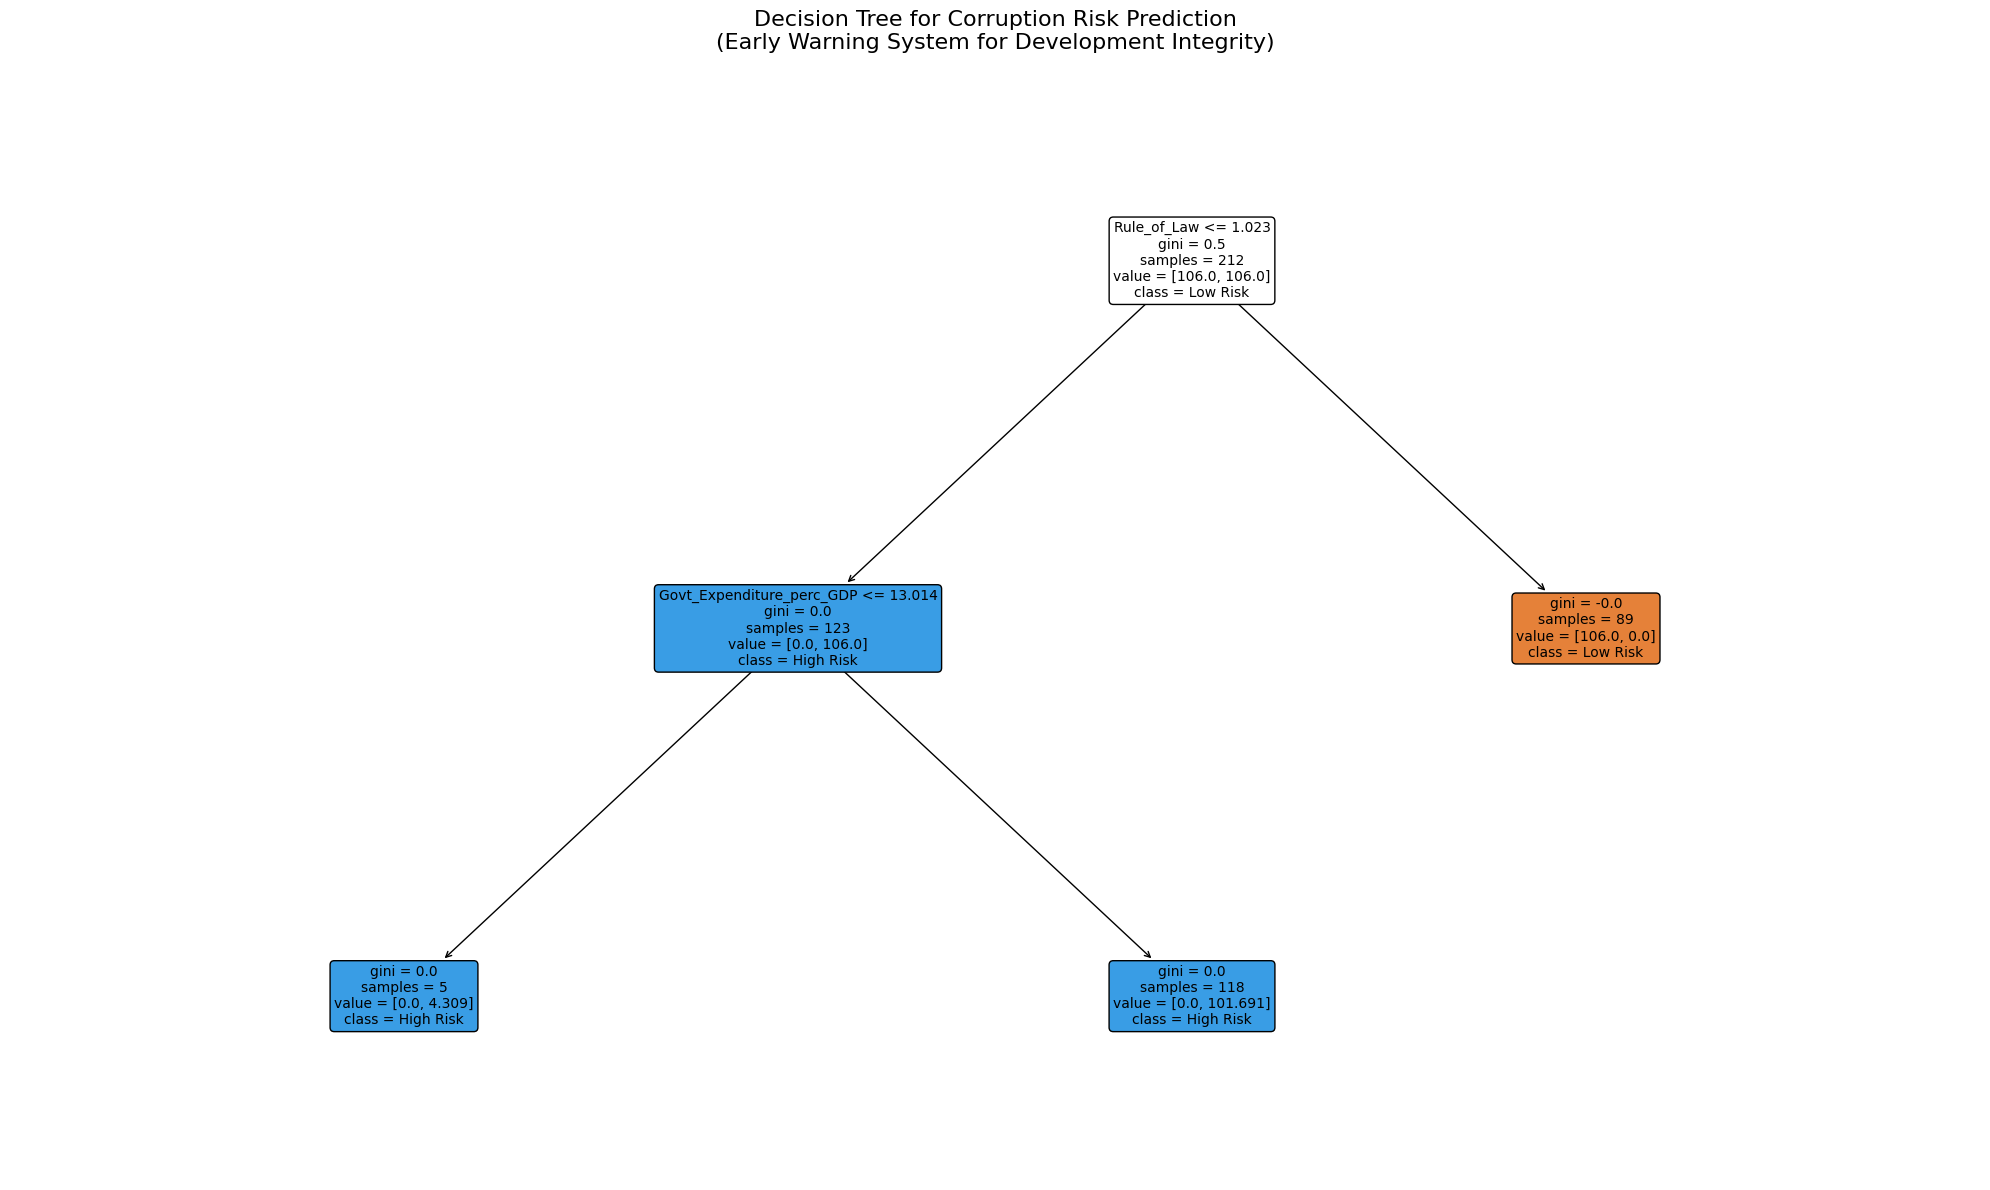

In [6]:
# create decision tree visualization
os.makedirs('results/figures', exist_ok=True)

fig, ax = plt.subplots(figsize=(20, 12))

plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=['Low Risk', 'High Risk'],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax
)

plt.title('Decision Tree for Corruption Risk Prediction\n(Early Warning System for Development Integrity)', 
          fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('results/figures/decision_tree_diagram.png', dpi=300, bbox_inches='tight')
print("="*70)
print("DECISION TREE VISUALIZATION")
print("="*70)
print("\n✓ saved decision tree diagram to results/figures/decision_tree_diagram.png")
print("\nThe tree shows the decision-making process:")
print("  - Each node shows the feature and threshold used for splitting")
print("  - Color intensity indicates class probability")
print("  - Leaf nodes show the final prediction (Low Risk or High Risk)")
plt.show()


## Section 6: Summary and Interpretation

### Model Performance Summary

The Decision Tree Classifier successfully learns patterns from governance indicators (primary signal) while incorporating economic context and sentiment (complementary signals). The model serves as an **early warning system** to identify high-risk environments before corruption scandals occur.

### Key Insights

1. **Governance indicators drive predictions**: As expected from the theoretical framework, governance indicators are the most important features. This validates that "measurable governance indicators can reliably signal early signs of financial and political vulnerability."

2. **Interpretability enables transparency**: The decision tree visualization provides clear, intuitive rules that stakeholders can understand and trust. This transparency is vital for an early warning system designed for development integrity.

3. **Early warning capability**: The model's recall metric (ability to catch high-risk cases) is critical for preventing corruption. High recall means the model correctly identifies most high-risk environments, enabling proactive intervention.

4. **Complementary signals enhance prediction**: Economic indicators and sentiment scores provide additional context beyond governance indicators, enriching the model's predictive power.

### Alignment with Theoretical Framework

- **Interpretability**: Decision tree chosen for transparency (per theory.txt)
- **Early warning system**: Model identifies high-risk environments proactively
- **Governance-based**: Model learns from governance indicators as primary signal
- **Qualitative enhancement**: Sentiment analysis adds qualitative early warning signals

### Next Steps

The trained model can now be used to:
- Predict corruption risk for new country-year observations
- Identify which indicators are most critical for risk assessment
- Provide interpretable explanations for risk classifications
- Support policy decisions for development fund allocation


In [7]:
# final summary
print("="*70)
print("MODEL TRAINING COMPLETE")
print("="*70)
print(f"\nModel Performance Summary:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}  (critical for early warning)")
print(f"  F1-score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

print(f"\nTop 3 Most Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['feature']:30s} ({row['importance']:.4f})")

print(f"\nDeliverables Created:")
print(f"  ✓ models/decision_tree_model.pkl - trained model")
print(f"  ✓ results/tables/model_performance.csv - performance metrics")
print(f"  ✓ results/tables/feature_importance.csv - feature importance scores")
print(f"  ✓ results/figures/decision_tree_diagram.png - decision tree visualization")

print(f"\n✓ Decision Tree training complete!")
print(f"  The model is ready for use as an early warning system for corruption risk.")


MODEL TRAINING COMPLETE

Model Performance Summary:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000  (critical for early warning)
  F1-score:  1.0000
  ROC-AUC:   1.0000

Top 3 Most Important Features:
  5. Rule_of_Law                    (1.0000)
  9. Govt_Expenditure_perc_GDP      (0.0000)
  1. Voice_Accountability           (0.0000)

Deliverables Created:
  ✓ models/decision_tree_model.pkl - trained model
  ✓ results/tables/model_performance.csv - performance metrics
  ✓ results/tables/feature_importance.csv - feature importance scores
  ✓ results/figures/decision_tree_diagram.png - decision tree visualization

✓ Decision Tree training complete!
  The model is ready for use as an early warning system for corruption risk.
